In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge

100% 96.6M/96.6M [00:02<00:00, 38.4MB/s]



In [ ]:
!mkdir data
!unzip facial-expression-recognitionferchallenge.zip -d data

Archive:  facial-expression-recognitionferchallenge.zip
  inflating: data/Submission.csv     
  inflating: data/fer2013/fer2013/README  
  inflating: data/fer2013/fer2013/fer2013.bib  
  inflating: data/fer2013/fer2013/fer2013.csv  


In [23]:
import numpy as np
import pandas as pd
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [24]:
df = pd.read_csv('data/fer2013/fer2013/fer2013.csv')
print(df.shape)
df=df[df['emotion']!=5 ]
df=df[df['emotion']!=6 ]
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training


In [25]:
df.emotion.unique()

array([0, 2, 4, 3, 1])

In [26]:
label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad'}

In [27]:
df.emotion.value_counts()

3    8989
4    6077
2    5121
0    4953
1     547
Name: emotion, dtype: int64

In [28]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

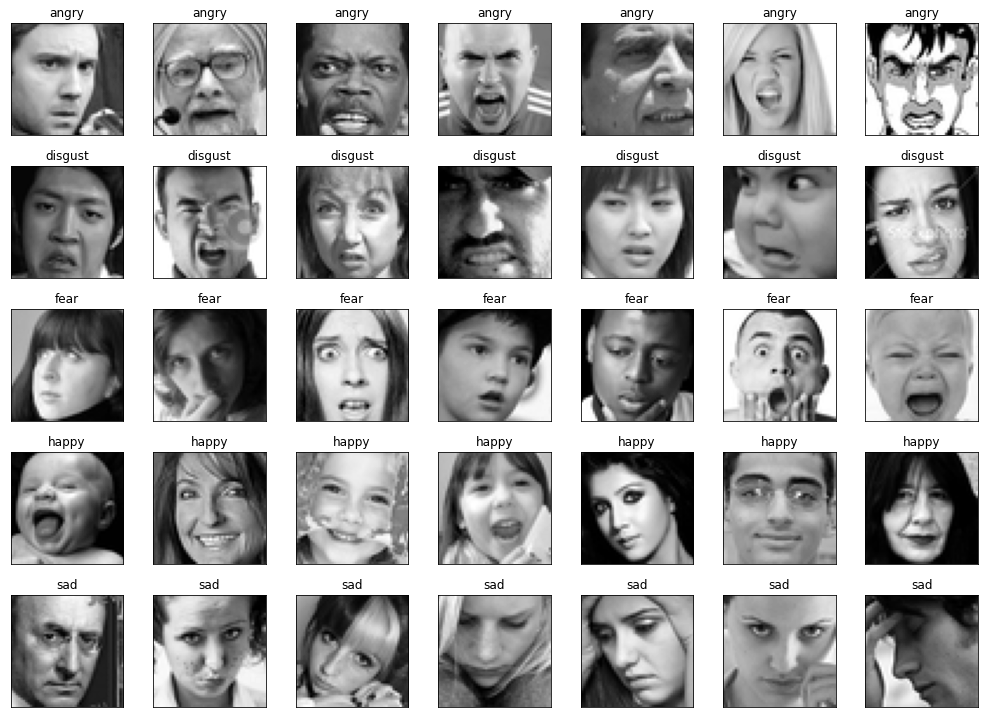

In [29]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [30]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [31]:
img_array.shape

(25687, 48, 48, 1)

In [32]:
from keras.utils import np_utils

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(25687, 5)

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23118, 48, 48, 1), (2569, 48, 48, 1), (23118, 5), (2569, 5))

In [34]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [37]:
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator=train_datagen.flow(X_train,y_train,batch_size=64)
validation_datagen = ImageDataGenerator(horizontal_flip=True)
validation_generator=validation_datagen.flow(X_valid,y_valid,batch_size=64)


In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(5,activation='softmax'),

])

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)      

In [41]:

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]



history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train) / 64,
    epochs=80,
    callbacks=callbacks
)

Epoch 1/80
362/361 [==============================] - ETA: 0s - loss: 1.7179 - accuracy: 0.3221
Epoch 00001: saving model to model_weights.h5
362/361 [==============================] - 15s 42ms/step - loss: 1.7179 - accuracy: 0.3221 - val_loss: 1.8149 - val_accuracy: 0.3542 - lr: 5.0000e-04
Epoch 2/80
361/361 [============================>.] - ETA: 0s - loss: 1.3985 - accuracy: 0.4218
Epoch 00002: saving model to model_weights.h5
362/361 [==============================] - 14s 40ms/step - loss: 1.3979 - accuracy: 0.4218 - val_loss: 1.4348 - val_accuracy: 0.4185 - lr: 5.0000e-04
Epoch 3/80
361/361 [============================>.] - ETA: 0s - loss: 1.2045 - accuracy: 0.4966
Epoch 00003: saving model to model_weights.h5
362/361 [==============================] - 14s 40ms/step - loss: 1.2041 - accuracy: 0.4968 - val_loss: 1.1279 - val_accuracy: 0.5127 - lr: 5.0000e-04
Epoch 4/80
361/361 [============================>.] - ETA: 0s - loss: 1.0692 - accuracy: 0.5585
Epoch 00004: saving model to

In [42]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)